# 误差反向传播

前面的内容介绍了，通过数值微分的方法，计算了误差函数关于权重和偏置的梯度。数值微分的方法，虽然简单直观，但是计算梯度时，需要多次计算误差函数，比较耗时。

本章介绍误差反向传播的方法计算梯度。利用计算图，将误差函数表示为计算图的节点。

## 计算图

将计算过程用图形表示出来，可以直观地看出计算过程，通过多个节点和边连接起来，每个节点代表一个计算单元，每个边代表两个计算单元之间的依赖关系。

例如：小明在日本买了2个100日元一个的苹果，消费税为10%，计算小明总共花了多少日元？

用计算图表示如下：

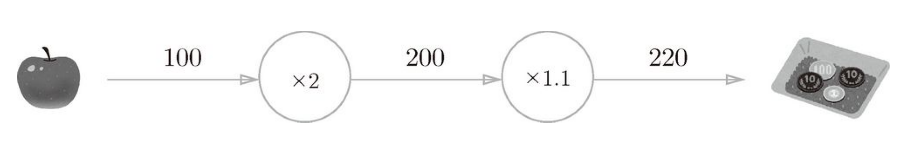

将运算看作节点，运算的输入和输出看作边。

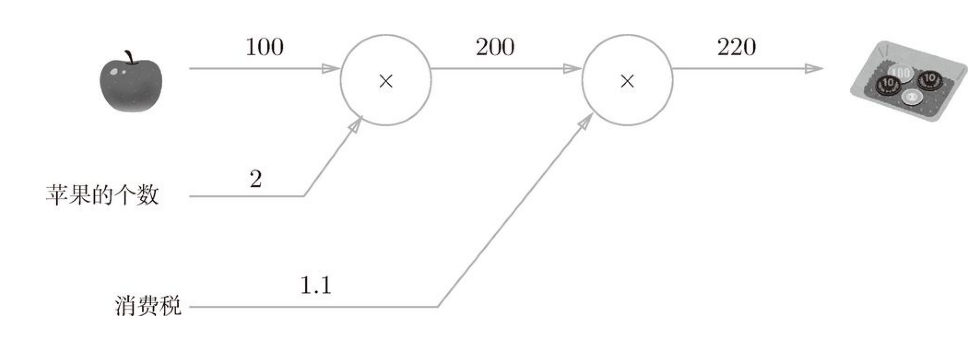

如果他还买了3个150日元一个的橘子。

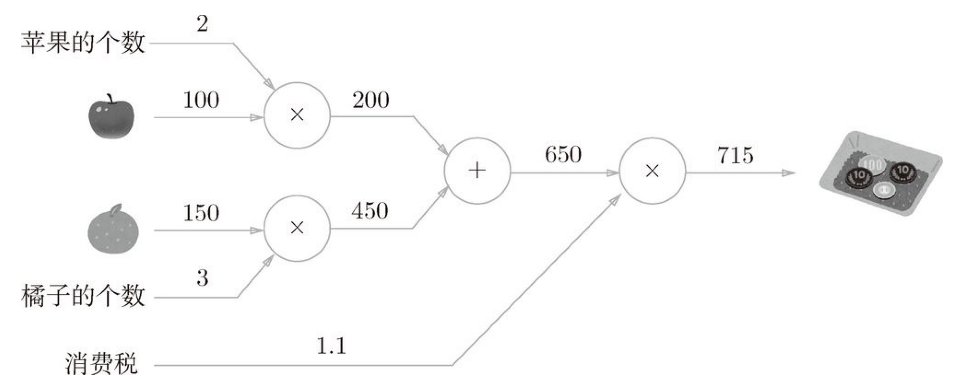

用计算图解题的流程：
- 构建计算图
- 在计算图上，从左到右遍历计算。

计算图中从左往右进行计算，被称为“**正向传播（forward propagation）**”。

从右往左进行计算，被称为“**反向传播（backward propagation）**”。

假设，想指导苹果价格的上涨会在多大程度上影响最终的支付金额，即求“支付金额关于苹果价格的导数”。

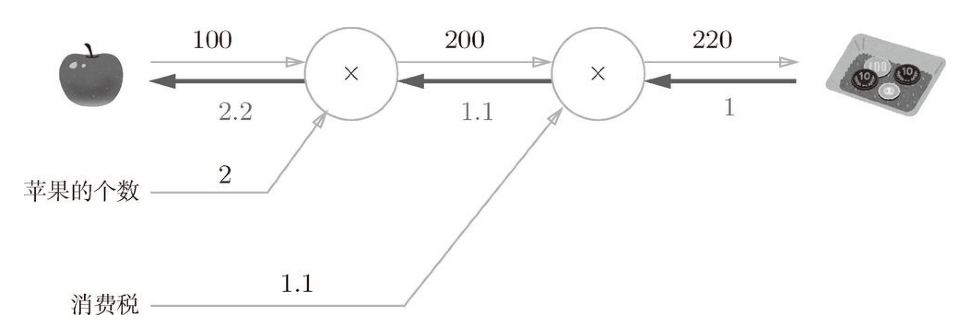


## 链式法则

反向传播将局部导数从右往左传播，这是基于链式法则的。假设有函数y=f(x)，这个计算的反向传播如下：

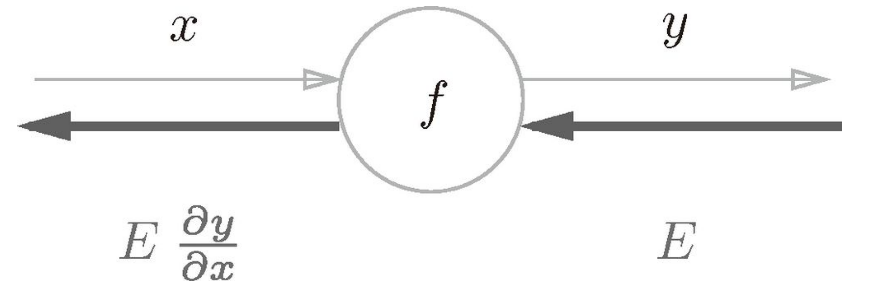

链式法则是关于复合函数求导的性质，定义为：如果某个函数由复合函数表示，则该复合函数的导数等于复合函数中各个函数的导数的乘积。例如，假设有函数 z=(x + y)^2。

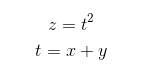

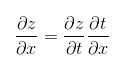

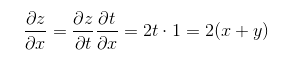

反向传播，乘以局部导数后进行传递：

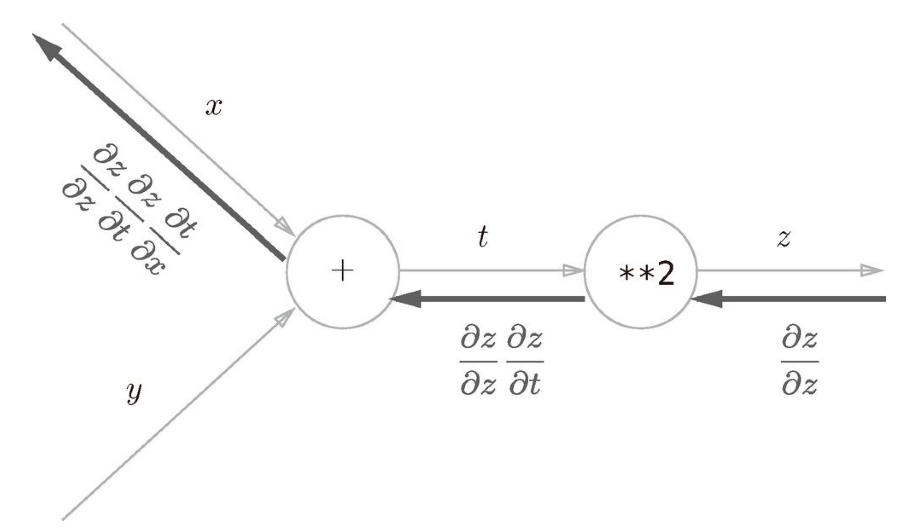


如图，计算图的方向传播从右到左传播信号，计算顺序是：先将节点的输入信号乘以节点的局部导数（偏导数），然后再传递给下一个节点。

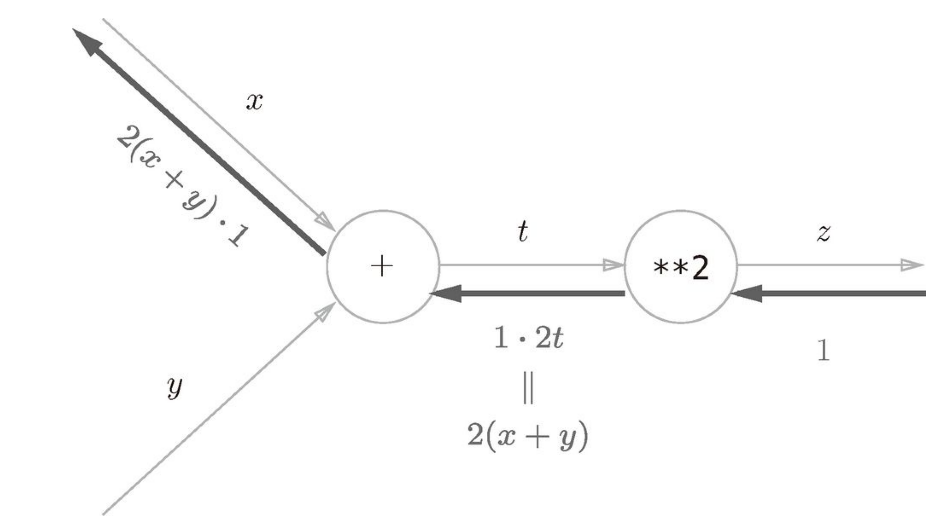

## 反向传播

以+和×为例。

### 加法节点的方向传播

假设z=x+y，则分别对x和y求偏导数，得到dz/dx=1, dz/dy=1，按照链式法则：

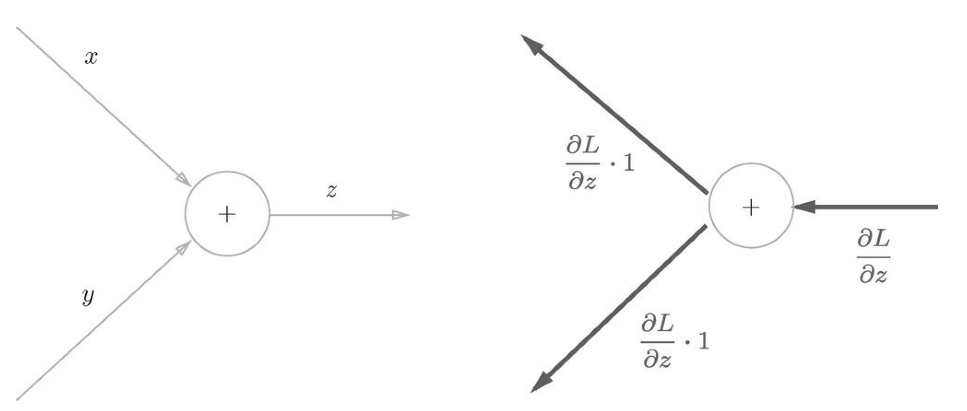

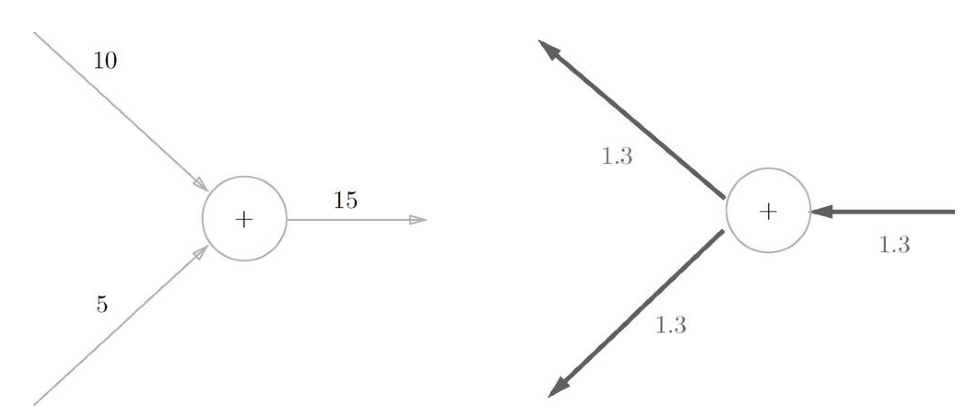


### 乘法节点的反向传播

假设z=xy，分别对x和y求偏导数，得到dz/dx=y, dz/dy=x。按照反向传播的规则：

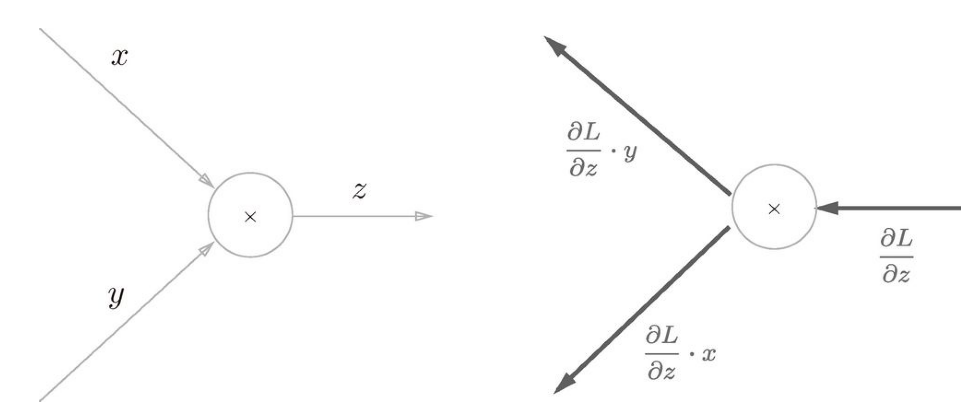

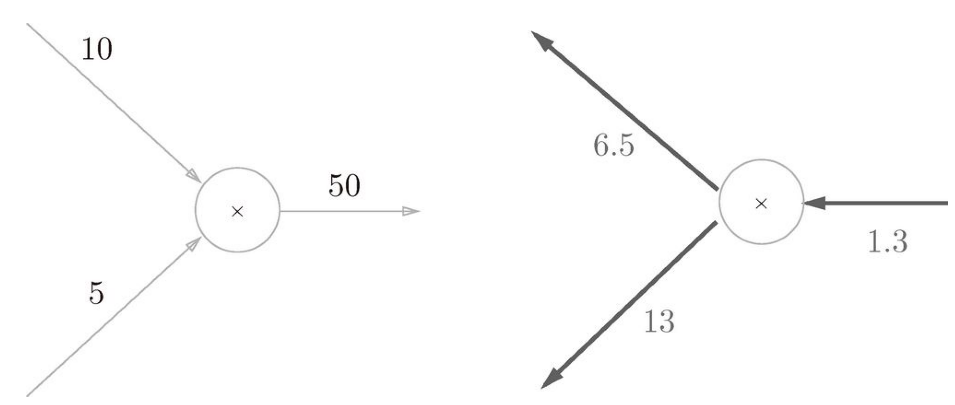

## 简单层的实现

分别实现“加法层”（AddLayer）和“乘法层”（MulLayer）。“层”是神经网络中的功能单位，如负责sigmoid函数的SigmoidLayer，负责加法运算的AddLayer等。

In [2]:
# 乘法层的实现
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        return out
    
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x
        return dx, dy

In [5]:
# 购买2个苹果
apple = 100
apple_num = 2
tax = 1.1

# Layer
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# Forward
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print("Forward: ",price)

# Backward
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dnum = mul_apple_layer.backward(dapple_price)
print("Backward: ", dapple, dnum, dtax)

Forward:  220.00000000000003
Backward:  2.2 110.00000000000001 200


In [6]:
# 加法层的实现
class AddLayer:
    def __init__(self):
        pass

    def forward(self, x, y):
        return x + y
    
    def backward(self, dout):
        dx = dout
        dy = dout
        return dx, dy

In [8]:
# 购买2个苹果和3个橘子
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

# backward
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print("Forward: ", price)
print("Backward: ", dapple_num, dapple, dorange_num, dorange, dall_price, dtax)

Forward:  715.0000000000001
Backward:  110.00000000000001 2.2 165.0 3.3000000000000003 1.1 650


## 激活函数层的实现

按照计算图的思路，应用到神经网络中，把神经网络的层实现为一个类，如ReLU层和Sigmoid层。

### ReLU层

激活函数ReLU（Rectified Linear Unit）：

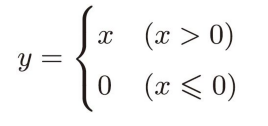 可以求出y关于x的导数 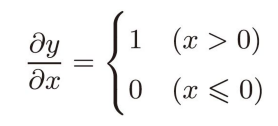

如果正向传播时的输入x大于0， 则反向传播会将上游的值原封不动地传给下游。反过来，如果正向传播时输入x小于或等于0，则反向传播中传给下游的信号将全部为0，即停在此处，不再向下游传播。

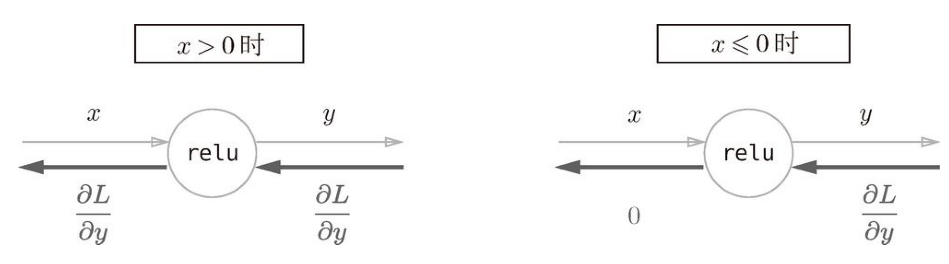


> 实现ReLU层的代码，详见common/layers.py。

### Sigmoid层

激活函数Sigmoid：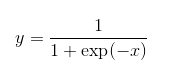 ，用计算图表示为：

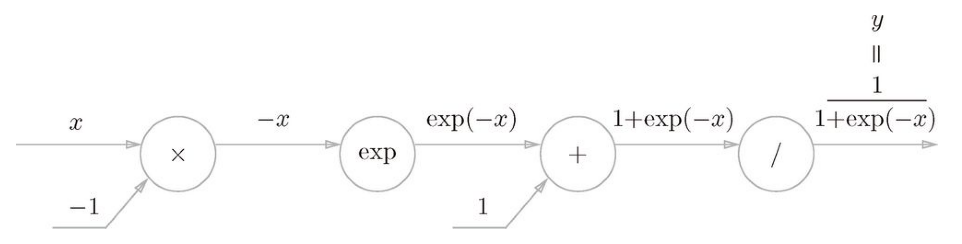

Sigmoid函数的计算图中，除了×和＋节点外，还出现了“exp”和“/”两个新的节点。其中，exp节点会进行y=exp(x)的计算，而/节点会进行y=1/x的计算。可得出其反向传播的流程为：

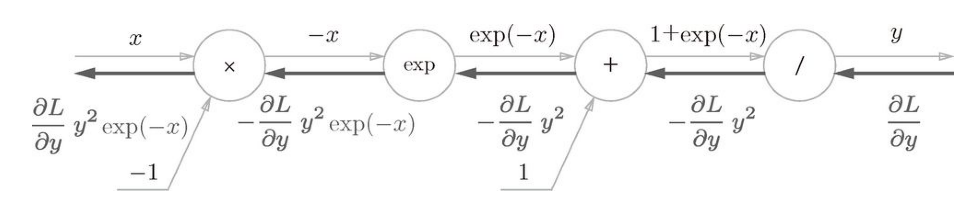

因此，Sigmoid函数的反向传播计算图可以集约化为：

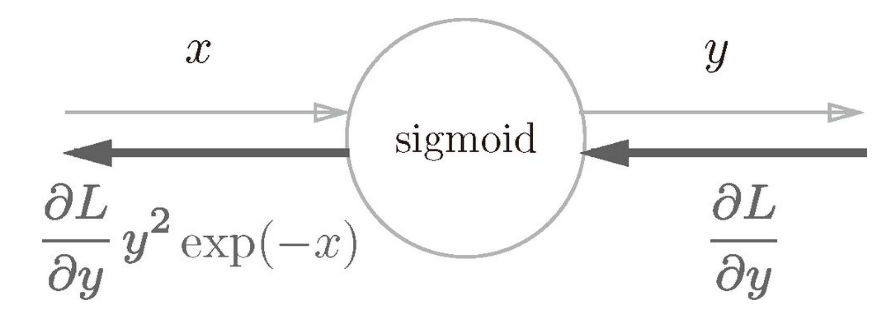

进一步整理公式，可得：

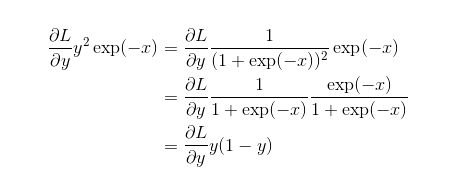

因此，Sigmoid函数的反向传播计算图最终可以简化为：

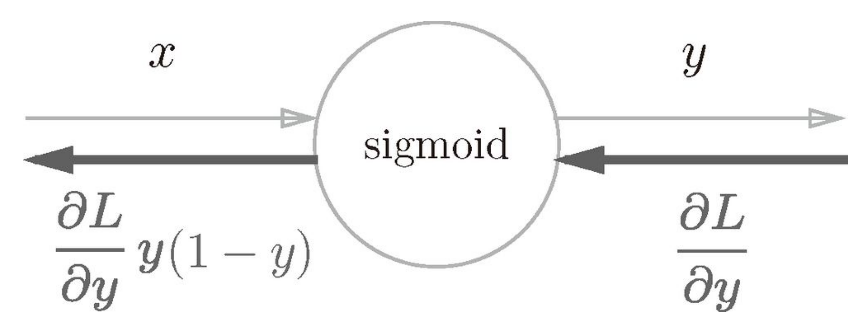

> 具体实现，详见common/layers.py。

## Affine / Softmax层

### Affine层

神经网络正向传播时，为了计算加权信号的总和，使用了矩阵乘法（NumPy的np.dot()方法）。由于输入X、权重W和偏置b都是矩阵，因此可以将其看作是一个多维数组。

矩阵乘法的要点是对应维度的元素个数必须保持一致。

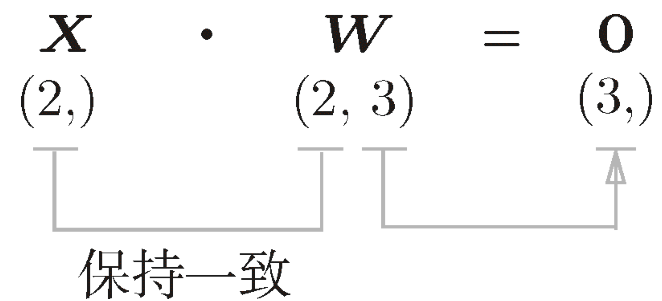

> 神经网络的正向传播中进行的矩阵乘法，称为**仿射变换（affine transformation）**。这种仿射变换也常被简称为**线性变换**。这里通过**Affine层**表示。

用计算图表示仿射变换：

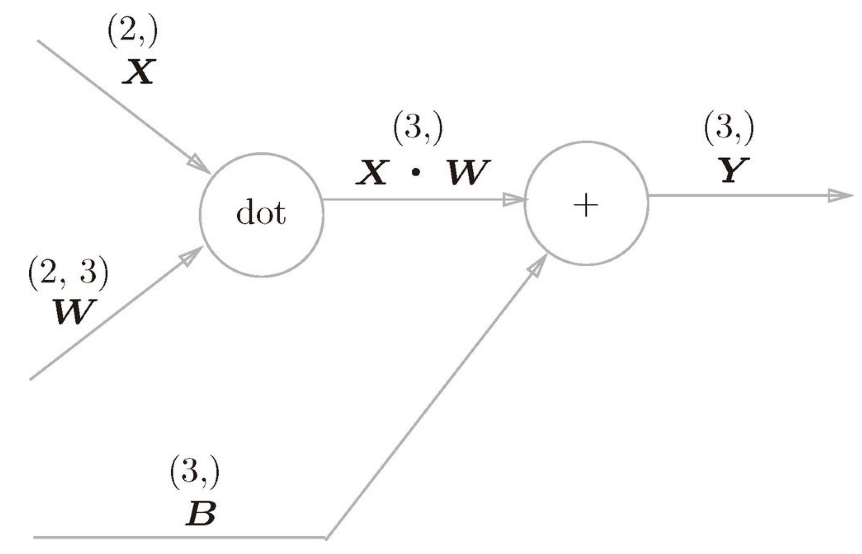

现在，我们考虑仿射变换的反向传播。以矩阵为对象的反向传播，按矩阵的各个元素进行计算，步骤和以标量为对象的计算图相同。

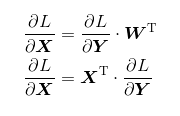

其中，WT表示W的转置，即会把w(i,j)变成w(j,i)。

那么，Affine层的方向传播计算图就可以表示为：

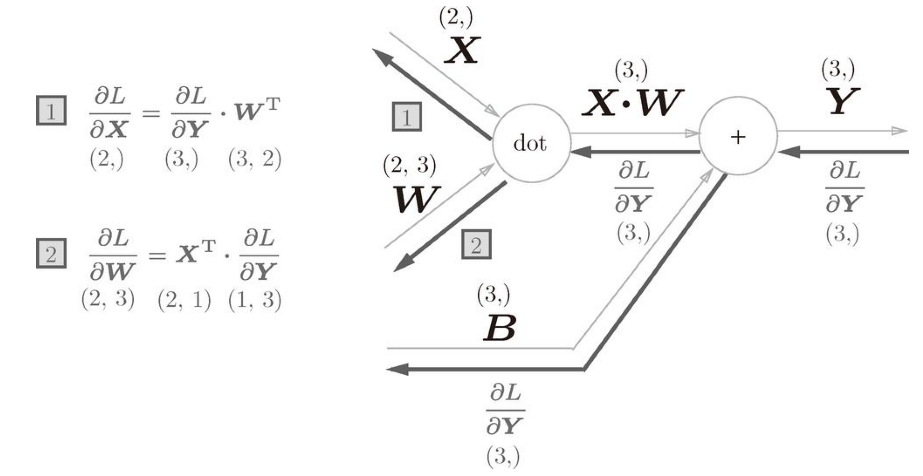

其中，dot节点的方向传播可以通过组建使矩阵对应维度的元素个数一致的乘积运算而推导出来。

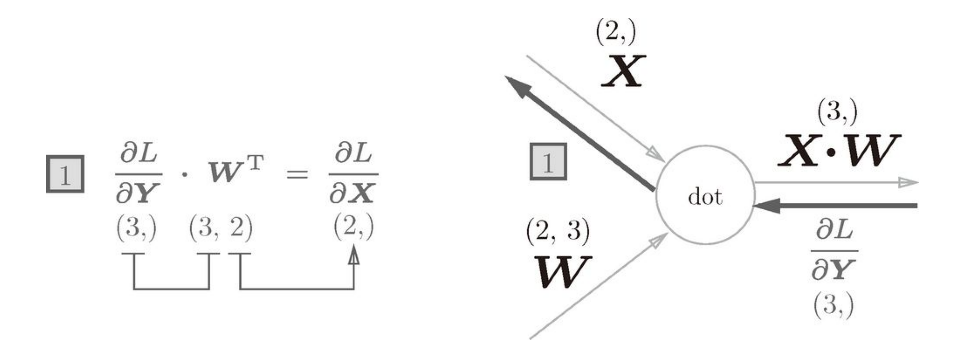

### 批版本的Affine层

当要考虑N个数据一起进行正向传播时，就需要用到批处理的Affine层。

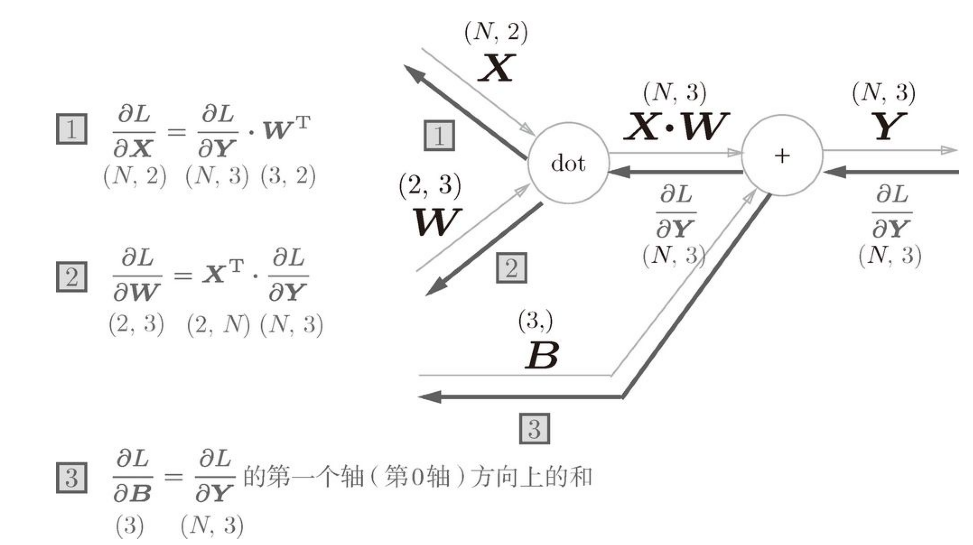

加上偏置时，需要注意，正向传播时，偏置被加上xw的各个数据上。

In [9]:
import numpy as np

X_dot_W = np.array([[0, 0, 0], [10, 10, 10]])
B = np.array([1, 2, 3])

print(X_dot_W)
print(X_dot_W + B)

[[ 0  0  0]
 [10 10 10]]
[[ 1  2  3]
 [11 12 13]]


因此，反向传播时，各个数据的方向传播的值需要汇总为偏置的元素，即偏置的梯度，其形状与偏置相同。

In [11]:
dY = np.array([[1, 2, 3], [4, 5, 6]])
print(dY)
dB = np.sum(dY, axis=0)
print(dB)

[[1 2 3]
 [4 5 6]]
[5 7 9]


> 综上，Affine层的实现考虑了输入数据的张量（四维数据）的情况。具体代码详见common/layers.py。

### Softmax-with-Loss层

Softmax函数会将输入值正则化后再输出，比如手写数字识别时，Softmax层的输出。

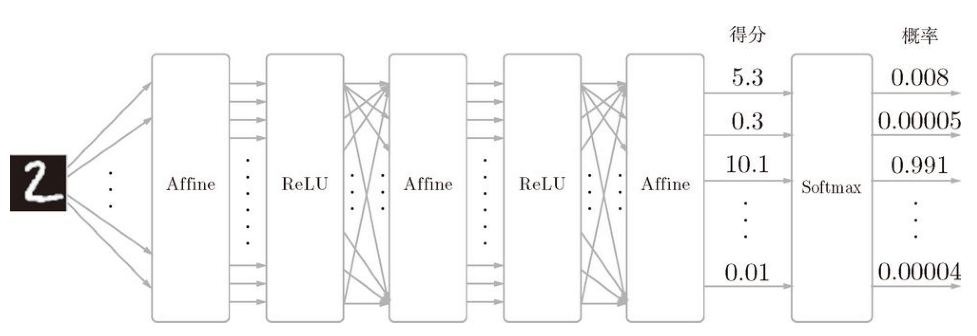

Softmax层将输入正则化后输出的结果之和为1，其中“2”的得分是10.1，被转换为0.991。

> 神经网络中进行的处理有推理和学习两个阶段。神经网络的推理通常不使用Softmax层，因为推理时不需要计算损失。但是，神经网络的学习需要使用Softmax层。

因此，这里也包含作为损失函数的交叉熵误差，称它为Softmax-with-Loss层。

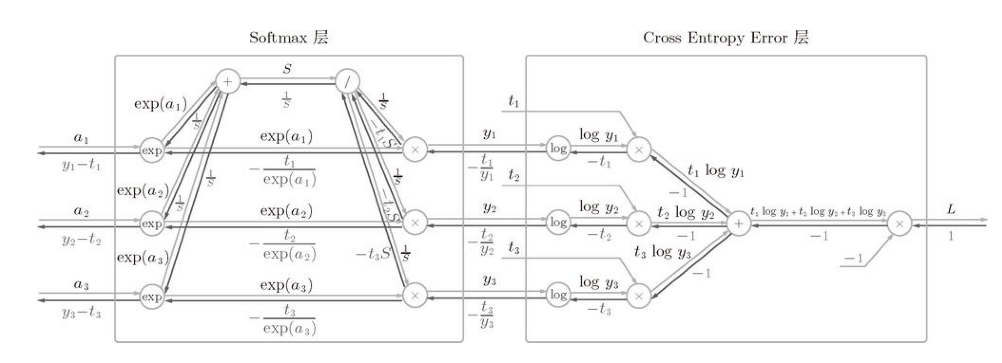

> 具体代码详见common/layers.py。